This notebook should have the figures necessary for the article 

IMPORTED
MODULE
/home/pdavid/Bureau/Code/SS_auto57/2D_cartesian/Updated_BCs/Code
ratio:  16
R:  0.9657036162531343
directness= 1
alpha: 500 must be greater than 400 
 for the Peaceman validation
h coarse: 48.0


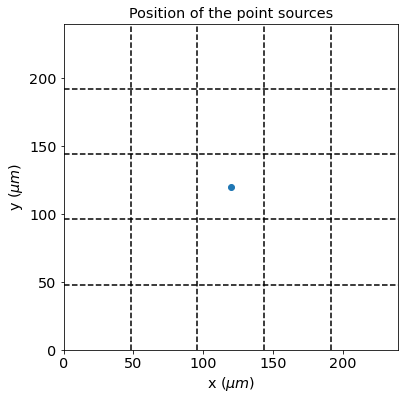

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Aug 26 11:14:07 2022

@author: pdavid

This script has been created as part of the virgin code to have something with 
the basic tools I'm commonly using, so everytime I wanna start some simulations
I have a script somewhat ready'
"""


#%% - First set the proper directory
import os 
directory='/home/pdavid/Bureau/Code/SS_auto57/2D_cartesian/Updated_BCs/Code'
os.chdir(directory)

from Assembly_diffusion import *
from Green import *
from Module_Coupling import *
from Neighbourhood import *
from reconst_and_test_module import *
from Reconstruction_functions import *
from Small_functions import *
from FV_reference import FV_validation

import random 
import scipy as sp
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6,6 ),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

#separation of scales
alpha=500

#physical parameters

D=1
K0=1

#Geometry
L=240
cells=5
h_ss=L/cells
ratio=int(40/cells)*2 #ratio for the reconstruction and validation 
print("ratio: ", ratio)
#ratio=12
#Rv=np.exp(-2*np.pi)*h_ss

#Parameterers non linear problem 
phi_0=0.4
Da_t=10
M=Da_t*D/L**2
conver_residual=5e-5
stabilization=0.5


print("R: ", 1/(1/K0 + np.log(alpha/(5*cells*ratio))/(2*np.pi*D)))
validation=True


#%%- Construction of the mesh 
x_ss=np.linspace(h_ss/2, L-h_ss/2, int(np.around(L/h_ss)))
y_ss=x_ss
directness=1
print("directness=", directness)

#%% - Definition of the source problem
pos_s=(np.array([[2.47 , 3.84],
       [1.56, 1.85],
       [4.29, 5.39],
       [5.2, 1.68],
       [4.39, 4.38],
       [4.59, 3.44]])/7*0.6+0.2)*L


pos_s=np.array([[0.5,0.5]])*L
S=len(pos_s)

C_v_array=np.ones(S)  

Rv=L/alpha+np.zeros(S)

print("alpha: {} must be greater than {} \n for the Peaceman validation".format(alpha, 5*ratio*cells))
print("h coarse:",h_ss)
K_eff=K0/(np.pi*Rv**2)

#Position image

vline=(y_ss[1:]+x_ss[:-1])/2
plt.scatter(pos_s[:,0], pos_s[:,1])
plt.title("Position of the point sources")
for xc in vline:
    plt.axvline(x=xc, color='k', linestyle='--')
for xc in vline:
    plt.axhline(y=xc, color='k', linestyle='--')
plt.xlim([0,L])
plt.ylim([0,L])
plt.ylabel("y ($\mu m$)")
plt.xlabel("x ($\mu m$)")
plt.show()


p=np.linspace(0,1,100)
if np.min(p-M*(1-phi_0/(phi_0+p)))<0: print("There is an error in the metabolism")


In [2]:

#%% - 1st solve the system through the hybrid model 

#The non_linear_metab class sets up the system to solve both the linear and non linear ones
n=non_linear_metab(pos_s, Rv, h_ss, L, K_eff, D, directness)

#We solve the linear problem given the intravascular concentration array C_v_array
n.solve_linear_prob(np.zeros(4), C_v_array)


#%%

if S > 1:
    plt.plot(n.phi_q, label="MyCode")
    plt.plot(FV.get_q(FV_linear), label="FV reference")
    plt.legend()
    plt.show()



#%% 3 - Reconstruction
b=post.reconstruction_sans_flux(np.concatenate((np.ndarray.flatten(n.phi_FV), n.phi_q)), n, L,ratio, directness)
p=b.reconstruction()   
b.reconstruction_boundaries(np.array([0,0,0,0]))
b.rec_corners()
plt.imshow(b.rec_final, origin='lower')
plt.title("bilinear reconstruction \n coupling model Steady State ")
plt.colorbar(); plt.show()




#%% 4
n.Full_Newton(np.ndarray.flatten(n.phi_FV) , np.ndarray.flatten(n.phi_q), conver_residual, M, phi_0)
a=post.reconstruction_sans_flux(n.phi[-1], n, L,ratio, directness)
p=a.reconstruction()   
a.reconstruction_boundaries(np.array([0,0,0,0]))
a.rec_corners()
plt.imshow(a.rec_final, origin='lower', vmax=np.max(a.rec_final))
plt.title("bilinear reconstruction \n coupling model Metabolism")
plt.colorbar(); plt.show()


n.assemble_it_matrices_Sampson(n.u, n.q)




#%% - 1st - FV resolution as a reference

FV=FV_validation(L, cells*ratio, pos_s, C_v_array, D, K_eff, Rv)
FV_linear=FV.solve_linear_system(dirichlet_array)
FV_linear_mat=FV_linear.reshape(cells*ratio, cells*ratio)

#%% Plots FV reference solution - Peaceman Coupling

plt.imshow(FV_linear_mat, origin='lower')
plt.colorbar()
plt.title("FV reference solution, linear system\n mesh:{}x{}".format(ratio*cells, ratio*cells))
plt.show()


#%% - 2nd set up non linear problem 

FV_non_linear=FV.solve_non_linear_system(phi_0,M, stabilization)
#phi_FV=FV_linear.reshape(cells*ratio, cells*ratio)
phi_FV=(FV.phi[-1]+FV.Corr_array).reshape(cells*ratio, cells*ratio)
phi_SS=(FV.phi[0]+FV.Corr_array).reshape(cells*ratio, cells*ratio)

#manual q
q_array=-np.dot(FV.A_virgin.toarray()[FV.s_blocks,:],FV.phi[-1])*FV.h**2/D+M*(1-phi_0/(FV.phi[-1, FV.s_blocks]+FV.Corr_array[FV.s_blocks]+phi_0))


#%%

plt.imshow(phi_SS, origin='lower', vmax=np.max(phi_FV))
plt.title("FV linear reference")
plt.colorbar(); plt.show()


#%%
plt.imshow(phi_FV, origin='lower', vmax=np.max(phi_FV))
plt.title("FV metab reference")
plt.colorbar(); plt.show()


#%% - Plots 
print("MRE steady state system", get_MRE(n.phi_q, FV.get_q(FV_linear)))

#%%
for i in pos_s:
    pos=coord_to_pos(FV.x, FV.y, i)
    
    plt.plot(FV_linear_mat[pos//len(FV.x),:], label="FV")
    plt.plot(b.rec_final[pos//len(FV.x),:],label="SS no metab")
    plt.legend()
    plt.title("Linear solution")
    plt.show()


for i in pos_s:
    pos=coord_to_pos(FV.x, FV.y, i)
    
    plt.plot(phi_FV[pos//len(FV.x),:], label="FV")
    plt.plot(a.rec_final[pos//len(FV.x),:],label="SS")
    plt.plot(b.rec_final[pos//len(FV.x),:],label="SS no metab")
    plt.legend()
    plt.show()

# =============================================================================
# c=0
# for i in pos_s:
#     pos=coord_to_pos(FV.x, FV.y, i)
#     
#     plt.plot(FV.x,phi_FV[pos//len(FV.x),:], label="FV")
#     plt.scatter(n.x,(n.rec_sing+n.u).reshape(cells, cells)[n.s_blocks[c]//cells,:],label="SS")
#     plt.plot(b.x,b.rec_final[pos//len(FV.x),:],label="SS no metab")
#     plt.legend()
#     plt.show()
#     c+=1
# =============================================================================

print("relative errors")
print(np.abs(n.phi[-1,-S:]-FV.get_q(FV.phi[-1]))/FV.get_q(FV.phi[-1]))

print("absolute error")
print(np.abs(n.phi[-1,-S:]-FV.get_q(FV.phi[-1])))

print("L2_error")
print(get_L2(n.phi[-1,-S:], FV.get_q(FV.phi[-1])))

print("MRE", get_MRE(n.phi[-1,-S:], FV.get_q(FV.phi[-1])))

u,pot=b.get_u_pot(C_v_array)


plt.subplots(2,2, figsize=(12,12))

plt.subplot(2,2,1)
plt.imshow(pot, origin='lower')
plt.title("SL + DL in $\overline{\Omega}$")
plt.colorbar()

plt.subplot(2,2,2)
plt.imshow(b.rec_potentials, origin="lower")
plt.title("SL in $\overline{\Omega} (old singular term)$")
plt.colorbar()

plt.subplot(2,2,3)
plt.imshow(u, origin="lower")
plt.title("u")
plt.colorbar()

plt.subplot(2,2,4)
plt.imshow(b.rec_final, origin="lower")
plt.title("$\phi$")
plt.colorbar()




TypeError: assembly_sol_split_problem() missing 1 required positional argument: 'BC_values'